## Lectura fitxer

In [1]:
import pandas as pd

In [2]:
df_students = pd.read_csv("datasets/Data Carrard.csv")
df_students = df_students.drop('id', axis = 1)

In [3]:
df_categorical = df_students[['sex', 'year', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]
df_numerical = df_students[['age', 'jspe', 'qcae_cog', 'qcae_aff', 'amsp', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']]

In [4]:
def sampleig_dataset(dataset, frac):
    dataset = dataset.sample(frac=frac).reset_index(drop=True)
    return dataset

In [5]:
frac_train = 0.7
frac_test = 0.3

X_train = sampleig_dataset(df_students, frac_train)
X_test = sampleig_dataset(df_students, frac_test)

## Aplicació model

In [6]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
from sklearn.metrics import make_scorer
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import rbf_kernel

# Precomputar la matriz de afinidad para X_train
affinity_matrix_train = rbf_kernel(X_train)

# Especificar el espacio de búsqueda de parámetros
param_grid = {
    "n_clusters": range(2, 8),
    "affinity": ['nearest_neighbors', 'rbf', 'nearest_neighbors', 'precomputed'],
}

# Crear una instancia de SpectralClustering
spectral_model = SpectralClustering()

# Crear una instancia de GridSearchCV
silhouette_scorer = make_scorer(silhouette_score)
grid_search = GridSearchCV(
    estimator=spectral_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=silhouette_scorer
)

# Ajustar el modelo al conjunto de entrenamiento y la matriz de afinidad
grid_search.fit(affinity_matrix_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Imprimir los mejores parámetros
print("Mejores Parámetros:", best_params)





c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(
c:\Users\LAURA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Mejores Parámetros: {'affinity': 'nearest_neighbors', 'n_clusters': 2}


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_numerical)

# Create a PCA instance: pca
pca = PCA(n_components=0.95)

# Fit the PCA instance to the scaled samples
pca.fit(df_num_scaled)

# Transform the scaled samples: pca_features
pca_features = pca.transform(df_num_scaled)

# Print the shape of pca_features
print("The shape of the pca is : ", pca_features.shape)

The shape of the pca is :  (886, 10)


In [10]:
n_grups = 3
model_gm = SpectralClustering(n_components=n_grups)
clusters = model_gm.fit_predict(pca_features)

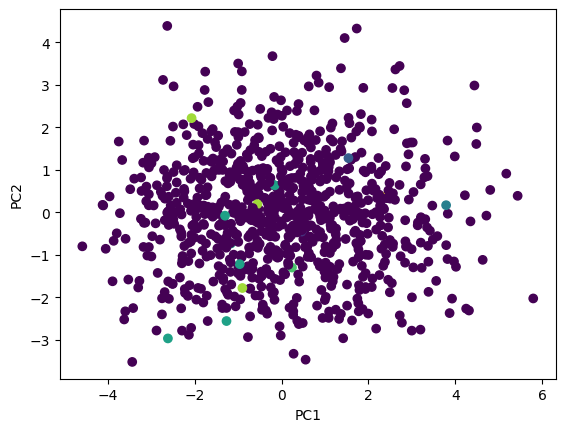

In [11]:
# scatter plot of the first two principal components
plt.scatter(pca_features[:,0], pca_features[:,1], c=clusters, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [14]:
cluster_labels = model_gm.labels_

In [15]:
df_clustered = df_numerical.copy() 
df_clustered['Cluster'] = cluster_labels 

In [16]:
df_clustered.head(5)

,age,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea,Cluster
0,18,88,62,27,17,0.738095,34,61,17,13,20,0
1,26,109,55,37,22,0.690476,7,33,14,11,26,0
2,21,106,64,39,17,0.690476,25,73,24,7,23,0
3,21,101,52,33,18,0.833333,17,48,16,10,21,0
4,21,102,58,28,21,0.690476,14,46,22,14,23,0


In [17]:
# Grouping the data frame by cluster to get the properties of each cluster
cluster_grouped = df_clustered.groupby('Cluster')
cluster_properties = cluster_grouped.mean()

# Printing the properties of each cluster (mean values of the variables)
print(cluster_properties)

               age        jspe   qcae_cog   qcae_aff       amsp  erec_mean  \
Cluster                                                                      
0        22.155963  106.339450  58.552752  34.795872  23.188073   0.720675   
1        39.000000   98.000000  65.000000  37.000000  22.000000   0.476190   
2        32.000000  101.000000  54.000000  28.000000  14.000000   0.619048   
3        35.000000   99.000000  59.000000  29.000000  22.000000   0.642857   
4        39.833333  112.333333  57.500000  35.500000  21.500000   0.769841   
5        37.000000  107.000000  68.000000  39.000000  17.000000   0.595238   
6        33.333333  110.666667  50.333333  33.333333  22.666667   0.682540   
7        30.000000  109.000000  54.000000  31.000000  19.000000   0.619048   

              cesd     stai_t     mbi_ex     mbi_cy     mbi_ea  
Cluster                                                         
0        17.974771  42.794725  16.901376  10.086009  24.193807  
1        28.000000  57.0

In [18]:
# Getting the number of patients in each cluster
cluster_grouped.size()

Cluster
0    872
1      1
2      1
3      1
4      6
5      1
6      3
7      1
dtype: int64

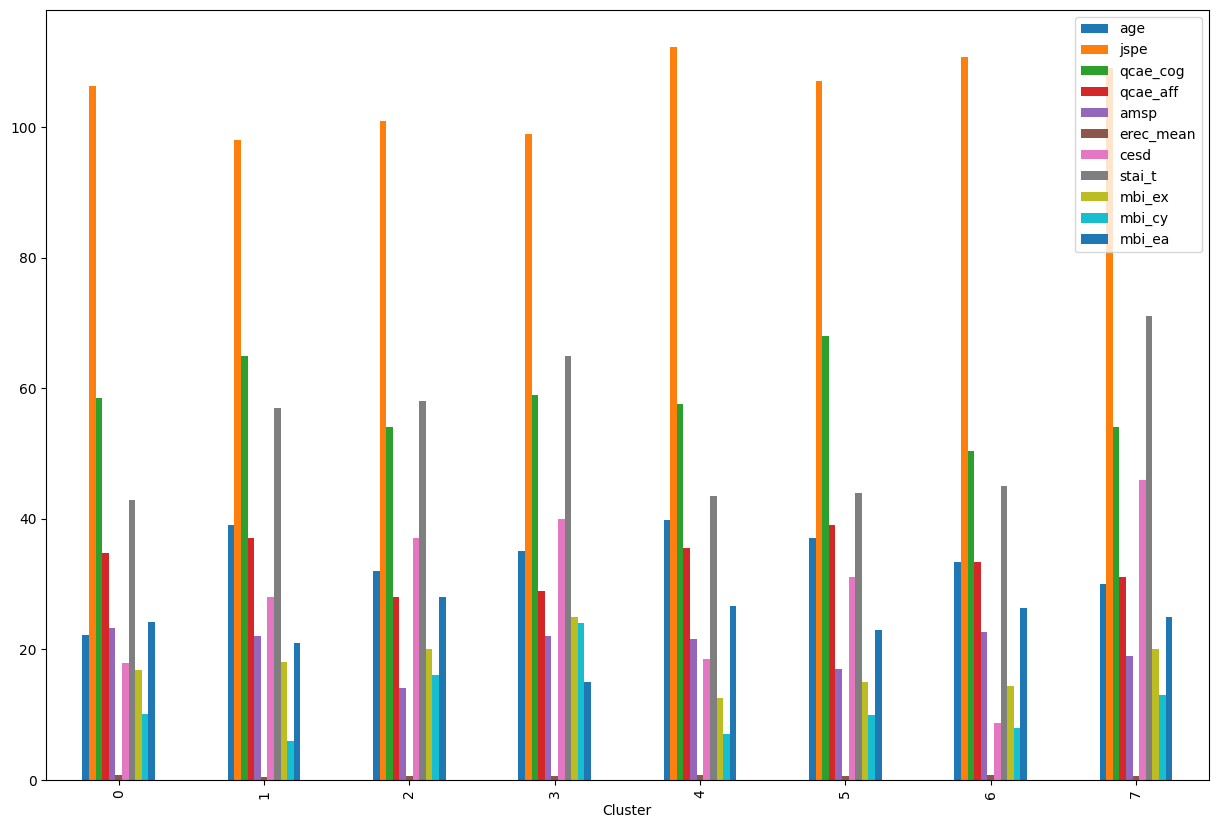

In [19]:
cluster_properties.plot(kind='bar', figsize=(15, 10))
plt.show()

## Accuracy

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(pca_features, cluster_labels, test_size=0.2, random_state=42) # 80% training and 20% test data sets

# Create a logistic regression classifier
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.9887640449438202
